In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import PIL
import os
import my_utils as mu

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


In [2]:
custom_transform = tv.transforms.Compose([
    tv.transforms.Resize((224,224)), #expected to be at least 224 in order to wrok with pretrained models
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) #for feature extractor
])

In [3]:
# set up directory structure if necessary
if not os.path.isdir('train_set'):
    os.mkdir('train_set')
    os.mkdir('train_set/people')
    os.mkdir('train_set/no_people')
if not os.path.isdir('test_set'):
    os.mkdir('test_set')
    os.mkdir('test_set/people')
    os.mkdir('test_set/no_people')

In [4]:
trainset = tv.datasets.ImageFolder('./train_set',transform = custom_transform)
testset = tv.datasets.ImageFolder('./test_set',transform = custom_transform)

In [5]:
b_size = 1
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size = b_size, shuffle = True, 
                                             num_workers=0,pin_memory=True)

testset_loader = torch.utils.data.DataLoader(testset, batch_size = b_size, shuffle = True, 
                                             num_workers=0,pin_memory=True)

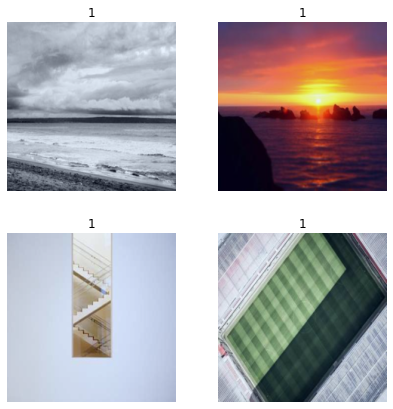

In [6]:
mu.plot_from_dataset(trainset,2,2)

In [7]:
class BasicNet(nn.Module):
    '''
    This network will take output from the feature extractor and hopefully do a good job at classifying the images.
    '''
    def __init__(self):
        super(BasicNet,self).__init__()
        self.dense1 = nn.Linear(1000,16)
        self.dense2 = nn.Linear(16,1)
        self.act1 = nn.LeakyReLU()
        self.act2 = nn.Sigmoid()
    def forward(self,x):
        x = feature_extractor(x)
        x = torch.flatten(x)
        x = self.dense1(x)
        x = self.act1(x)
        x = self.dense2(x)
        x = self.act2(x)
        return x

/home/armobob74/envs/ML/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Text(0.5, 1.0, 'Category 972')

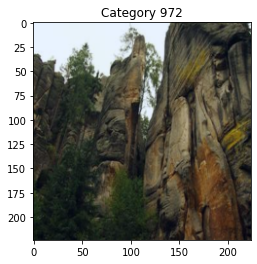

In [8]:
#define feature extractor
feature_extractor = tv.models.squeezenet1_1(pretrained=True).to(device) #I tried other backbones but this works best. It's also light!
feature_extractor.train(False) #don't wanna accidentally train it later

#let's see how feature extractor feels about an image
batch_it = iter(trainset_loader)
batch,target = next(batch_it)
a = feature_extractor(batch.to(device)) #returns tensor of size (1,1000). These are the 1000 imagenet categories. 
m = a.max();
n = 0;
while a[0][n] != m: n+=1 #find max value, and that's the classification

img = mu.prepare_for_pyplot(batch[0])
plt.imshow(img)
plt.title("Category "+str(n))

In [9]:
net = BasicNet() 
net = net.to(device)
print(net)

BasicNet(
  (dense1): Linear(in_features=1000, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=1, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (act2): Sigmoid()
)


In [10]:
#training time!
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.00005)

epoch_loss_list = [];
test_loss_list = [];
max_epochs = 15

original_loss = mu.evaluate_epoch_loss(net,trainset_loader,criterion)

print("--- Untrained loss: "+str(original_loss)+" ---")
for E in range(max_epochs):
    epoch_loss = 0
    batch_it = iter(trainset_loader)
    for i in range(len(trainset_loader)):
        optimizer.zero_grad()
        batch,target = next(batch_it)
        target = target.to(device)
        output = net(batch.to(device))
    
        loss = criterion(output,target/1) #divide by 1 so it becomes a float
        loss.backward()
        epoch_loss += output.shape[0] *loss.item()
        optimizer.step()
        
    epoch_loss = epoch_loss / len(trainset_loader)
    test_loss = mu.evaluate_epoch_loss(net,testset_loader,criterion)
    epoch_loss_list.append(epoch_loss)
    test_loss_list.append(test_loss)
    n = range(len(test_loss_list))
    num_spaces = len(str(max_epochs))-len(str(E))+1 #for pretty formatting of log
    print("[Epoch"+" "*num_spaces+str(E)+"] Training Loss: "+ str(epoch_loss)[0:6]+", Test Loss:"+ str(test_loss)[0:6])

--- Untrained loss: 0.544619232043624 ---
[Epoch  0] Training Loss: 0.3055, Test Loss:0.2167
[Epoch  1] Training Loss: 0.1350, Test Loss:0.1255
[Epoch  2] Training Loss: 0.0862, Test Loss:0.0873
[Epoch  3] Training Loss: 0.0636, Test Loss:0.0677
[Epoch  4] Training Loss: 0.0496, Test Loss:0.0538
[Epoch  5] Training Loss: 0.0399, Test Loss:0.0441
[Epoch  6] Training Loss: 0.0328, Test Loss:0.0363
[Epoch  7] Training Loss: 0.0278, Test Loss:0.0314
[Epoch  8] Training Loss: 0.0240, Test Loss:0.0275
[Epoch  9] Training Loss: 0.0212, Test Loss:0.0243
[Epoch 10] Training Loss: 0.0190, Test Loss:0.0220
[Epoch 11] Training Loss: 0.0174, Test Loss:0.0201
[Epoch 12] Training Loss: 0.0161, Test Loss:0.0185
[Epoch 13] Training Loss: 0.0150, Test Loss:0.0173
[Epoch 14] Training Loss: 0.0141, Test Loss:0.0164


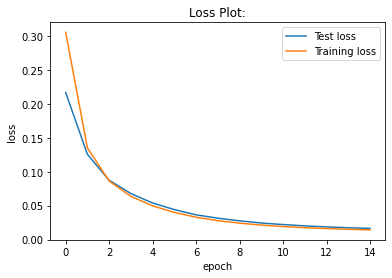

In [11]:
mu.plot_loss(test_loss_list,epoch_loss_list,title="Loss Plot:")
save_path = './training_run_data/' #make sure this ends with '/'
mu.save_loss_plot(optimizer,save_path)

In [12]:
torch.save(net.state_dict(),'./training_run_data/latest_state_dict.pkl') 

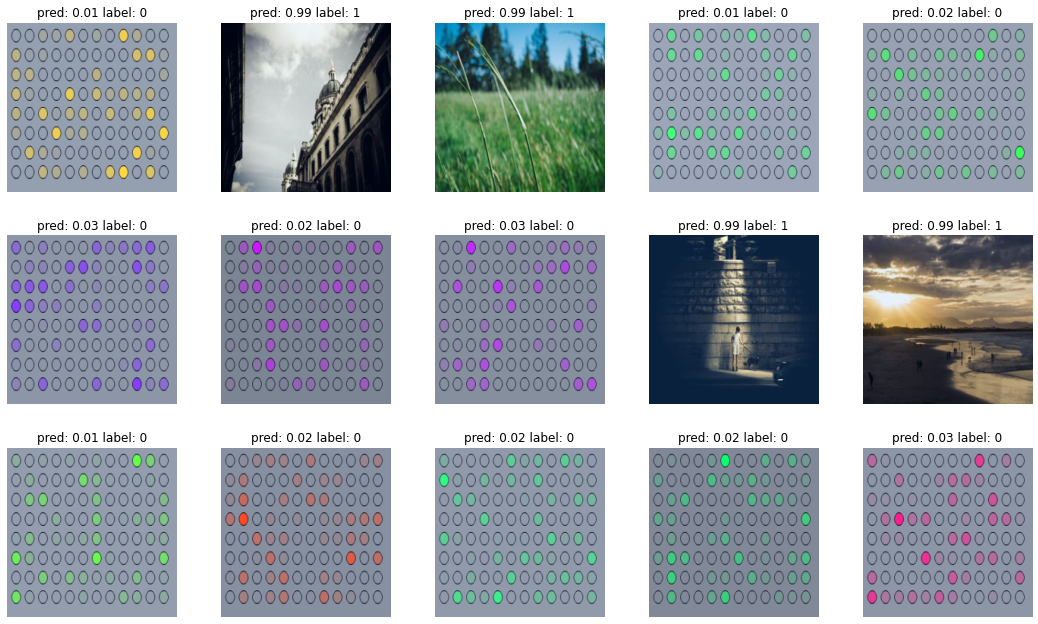

{'pred 0 label 1': 0,
 'pred 0 label 0': 11,
 'pred 1 label 1': 4,
 'pred 1 label 0': 0}

In [14]:
mu.plot_tests(net,testset,3,5) #0 means human and 1 means no human


In [ ]:
mu.plot_tests(net,trainset,3,3) #now let's plot results from the training set